# Proyek Klasifikasi Gambar: [Input Nama Dataset]
- **Nama:** Habib Fabri Arrosyid
- **Email:** habibarrsyd@gmail.com
- **ID Dicoding:** habibarrsyd

## Import Semua Packages/Library yang Digunakan

In [42]:
import zipfile
import os
import shutil
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from google.colab import files
from PIL import Image
from tensorflow.keras.models import load_model

In [16]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.6 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


## Data Preparation

### Data Loading

In [2]:
# Lokasi file zip dan lokasi ekstrak
zip_file = '/content/archive (8).zip'
extract_folder = '/content/satelit'

# Mengekstrak file zip
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print(f"Dataset telah diekstrak ke {extract_folder}")

Dataset telah diekstrak ke /content/satelit


### Data Preprocessing

#### Split Dataset

In [3]:
# Tentukan path untuk folder train, validation, dan test
train_dir = '/content/satelit/data/train'
val_dir = '/content/satelit/data/validation'
test_dir = '/content/satelit/data/test'

# Membuat folder untuk train, validation, dan test jika belum ada
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Tentukan path ke folder buah
base_folder = '/content/satelit/data'

# Daftar folder kelas buah setelah ekstraksi
class_names = os.listdir(base_folder)

# Membagi gambar menjadi data train, validation, dan test
def split_data(class_name, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    class_folder = os.path.join(base_folder, class_name)
    all_images = os.listdir(class_folder)

    # Mengacak gambar
    random.shuffle(all_images)

    # Hitung jumlah data untuk masing-masing set
    total_images = len(all_images)
    train_size = int(total_images * train_ratio)
    val_size = int(total_images * val_ratio)

    # Memindahkan gambar ke folder train, validation, dan test
    for i, image_name in enumerate(all_images):
        src = os.path.join(class_folder, image_name)

        # Pastikan ini adalah file, bukan folder
        if os.path.isfile(src):
            if i < train_size:
                dst = os.path.join(train_dir, class_name, image_name)
            elif i < train_size + val_size:
                dst = os.path.join(val_dir, class_name, image_name)
            else:
                dst = os.path.join(test_dir, class_name, image_name)

            # Membuat subfolder untuk kelas jika belum ada
            os.makedirs(os.path.dirname(dst), exist_ok=True)

            shutil.copy(src, dst)

# Membagi data untuk setiap kelas
for class_name in class_names:
    split_data(class_name)

In [5]:
# Normalisasi dan augmentasi untuk data latih
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Hanya normalisasi untuk data validasi
validation_datagen = ImageDataGenerator(rescale=1./255)

# Hanya normalisasi untuk data test
test_datagen = ImageDataGenerator(rescale=1./255)

# Menggunakan flow_from_directory untuk data latih
train_generator = train_datagen.flow_from_directory(
    '/content/satelit/data/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

# Menggunakan flow_from_directory untuk data validasi
validation_generator = validation_datagen.flow_from_directory(
    '/content/satelit/data/validation',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

# Menggunakan flow_from_directory untuk data test
test_generator = test_datagen.flow_from_directory(
    '/content/satelit/data/test',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 3941 images belonging to 4 classes.
Found 844 images belonging to 4 classes.
Found 846 images belonging to 4 classes.


## Modelling

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Membangun model CNN dari scratch
model_scratch = Sequential()

# Layer konvolusi pertama
model_scratch.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model_scratch.add(MaxPooling2D(pool_size=(2, 2)))

# Layer konvolusi kedua
model_scratch.add(Conv2D(64, (3, 3), activation='relu'))
model_scratch.add(MaxPooling2D(pool_size=(2, 2)))

# Layer konvolusi ketiga
model_scratch.add(Conv2D(128, (3, 3), activation='relu'))
model_scratch.add(MaxPooling2D(pool_size=(2, 2)))

# Flattening untuk memasukkan data ke layer Dense
model_scratch.add(Flatten())

# Fully connected layer
model_scratch.add(Dense(512, activation='relu'))
model_scratch.add(Dropout(0.5))
model_scratch.add(Dense(4, activation='softmax'))

# Kompilasi model
model_scratch.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Melihat ringkasan model
model_scratch.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,035,716 (72.62 MB)

 Trainable params: 19,035,716 (72.62 MB)

 Non-trainable params: 0 (0.00 B)

## Evaluasi dan Visualisasi

In [7]:
from tensorflow.keras.callbacks import Callback

class StopTrainingAtAccuracy(Callback):
    def __init__(self, target=0.92):
        super(StopTrainingAtAccuracy, self).__init__()
        self.target = target

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get("val_accuracy")
        if val_acc is not None:
            if val_acc >= self.target:
                print(f"\n✅ Target val_accuracy {self.target*100:.0f}% tercapai, menghentikan pelatihan.")
                self.model.stop_training = True


In [8]:
stop_callback = StopTrainingAtAccuracy(target=0.92)

history_scratch = model_scratch.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[stop_callback]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 33s 222ms/step - accuracy: 0.5606 - loss: 0.8735 - val_accuracy: 0.7861 - val_loss: 0.4539
Epoch 2/50
  1/123 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6875 - loss: 0.5799

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6875 - loss: 0.5799 - val_accuracy: 0.6935 - val_loss: 0.4878
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 25s 203ms/step - accuracy: 0.7999 - loss: 0.4287 - val_accuracy: 0.8702 - val_loss: 0.3249
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8125 - loss: 0.5107 - val_accuracy: 0.8750 - val_loss: 0.2977
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 41s 212ms/step - accuracy: 0.8137 - loss: 0.4127 - val_accuracy: 0.8870 - val_loss: 0.2905
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9062 - loss: 0.3448 - val_accuracy: 0.8822 - val_loss: 0.2904
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 24s 195ms/step - accuracy: 0.8611 - loss: 0.3475 - val_accuracy: 0.8209 - val_loss: 0.3458
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9062 - loss: 0.2539 - val_accuracy: 0.7680 - val_loss: 0.3922
Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 41s 335ms/step - accuracy: 0.8510 - loss: 0.3243 - val_accuracy: 

In [9]:
# Evaluasi pada data train
train_loss, train_accuracy = model_scratch.evaluate(
    train_generator,
    steps=train_generator.samples // train_generator.batch_size
)

# Evaluasi pada data validasi
val_loss, val_accuracy = model_scratch.evaluate(
    validation_generator,
    steps=validation_generator.samples // validation_generator.batch_size
)

# Evaluasi pada data test
test_loss, test_accuracy = model_scratch.evaluate(
    test_generator,
    steps=test_generator.samples // test_generator.batch_size
)

# Tampilkan hasil evaluasi
print("\n📊 Evaluasi Akhir Model:")
print(f"Train Accuracy   : {train_accuracy * 100:.2f}%")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Test Accuracy    : {test_accuracy * 100:.2f}%")


123/123 ━━━━━━━━━━━━━━━━━━━━ 23s 184ms/step - accuracy: 0.8829 - loss: 0.2714
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8718 - loss: 0.2993
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9094 - loss: 0.1963

📊 Evaluasi Akhir Model:
Train Accuracy   : 88.21%
Validation Accuracy: 87.86%
Test Accuracy    : 87.02%


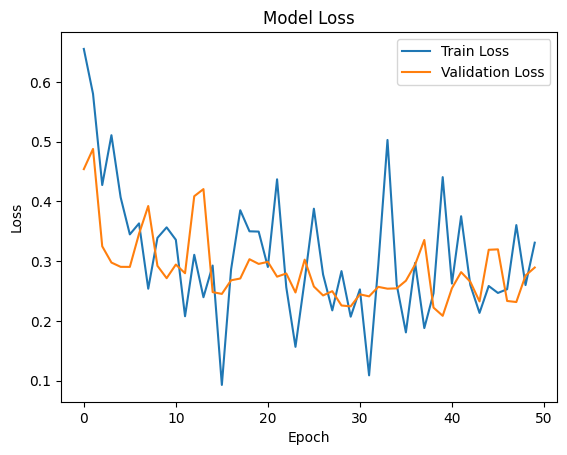

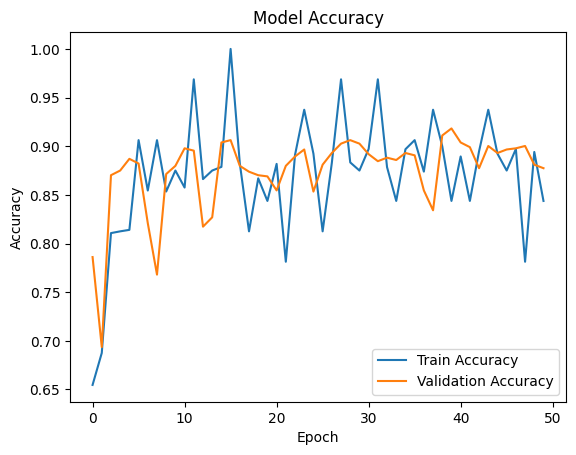

In [12]:
# Plot loss
plt.plot(history_scratch.history['loss'], label='Train Loss')
plt.plot(history_scratch.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history_scratch.history['accuracy'], label='Train Accuracy')
plt.plot(history_scratch.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step


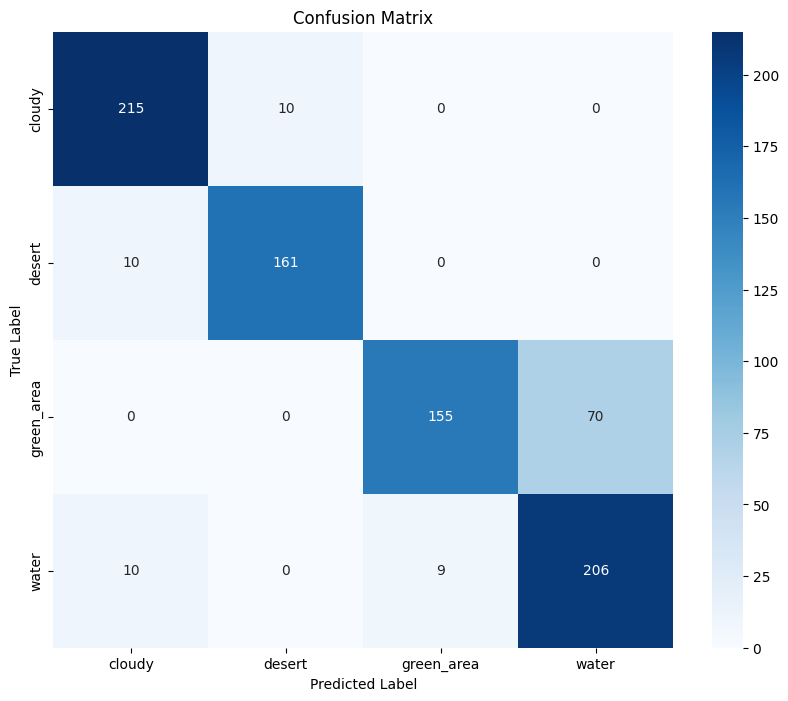

Classification Report:
              precision    recall  f1-score   support

      cloudy       0.91      0.96      0.93       225
      desert       0.94      0.94      0.94       171
  green_area       0.95      0.69      0.80       225
       water       0.75      0.92      0.82       225

    accuracy                           0.87       846
   macro avg       0.89      0.88      0.87       846
weighted avg       0.88      0.87      0.87       846



In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 1. Ambil prediksi dari model
test_generator.reset()  # Penting untuk menghindari shuffle atau batch yang tersisa
pred_probs = model_scratch.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
pred_classes = np.argmax(pred_probs, axis=1)

# 2. Ambil label asli
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# 3. Confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

# 4. Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 5. Print classification report
print("Classification Report:")
print(classification_report(true_classes, pred_classes, target_names=class_labels))


## Konversi Model

In [39]:
# === 1. Simpan Model dalam Format SavedModel ===
saved_model_dir = '/content/satelit/saved_model'
os.makedirs(saved_model_dir, exist_ok=True)  # Buat folder jika belum ada

# Simpan dalam format SavedModel
model_scratch.export(saved_model_dir)

print("✅ Model berhasil disimpan dalam format SavedModel.")

# === 2. Konversi ke TF-Lite ===
tflite_dir = '/content/satelit/tflite'
os.makedirs(tflite_dir, exist_ok=True)

# Inisialisasi konverter TF-Lite dari SavedModel
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)

# Optimasi ukuran model (opsional)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Konversi
tflite_model = converter.convert()

# Simpan ke file
with open(os.path.join(tflite_dir, 'model.tflite'), 'wb') as f:
    f.write(tflite_model)
print("✅ Model berhasil dikonversi dan disimpan dalam format TF-Lite.")

# Simpan label kelas (opsional)
class_labels = list(train_generator.class_indices.keys())
with open(os.path.join(tflite_dir, 'label.txt'), 'w') as f:
    for label in class_labels:
        f.write(f"{label}\n")
print("✅ Label kelas berhasil disimpan dalam label.txt.")

# === 3. Konversi ke TensorFlow.js ===
tfjs_dir = '/content/satelit/tfjs'
os.makedirs(tfjs_dir, exist_ok=True)

# Pastikan tensorflowjs terinstal (komentar jika sudah terinstall)
# %pip install tensorflowjs

import tensorflowjs as tfjs
# Konversi model Keras (bukan SavedModel) ke format TFJS
tfjs.converters.save_keras_model(model_scratch, tfjs_dir)
print("✅ Model berhasil disimpan dalam format TensorFlow.js.")


Saved artifact at '/content/satelit/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  136890848702928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136891724723216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136890811779024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136890811779408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136890811781328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136890811782096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136890811781904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136890811782288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136890811780560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136890811784208: TensorSpec(shape=(), dtype=tf.resource, name=None)
✅ Mo

✅ Model berhasil dikonversi dan disimpan dalam format TF-Lite.
✅ Label kelas berhasil disimpan dalam label.txt.
failed to lookup keras version from the file,
    this is likely a weight only file
✅ Model berhasil disimpan dalam format TensorFlow.js.


## Inference (Optional)

In [41]:
# === 1. Load TFLite model ===
tflite_model_path = '/content/satelit/tflite/model.tflite'

# Inisialisasi interpreter TFLite
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Ambil detail input/output
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Ukuran input model (biasanya [1, 224, 224, 3])
input_shape = input_details[0]['shape']

# === 2. Load class labels ===
with open('/content/satelit/tflite/label.txt', 'r') as f:
    class_labels = [line.strip() for line in f.readlines()]

# === 3. Upload dan uji gambar ===
uploaded = files.upload()

for filename in uploaded.keys():
    print(f"\n🔍 Menguji gambar: {filename}")

    # Baca gambar dan ubah ukurannya sesuai model
    img = Image.open(filename).convert('RGB')
    img = img.resize((input_shape[1], input_shape[2]))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # normalisasi sesuai train_datagen
    img_array = np.expand_dims(img_array, axis=0).astype(np.float32)

    # Set input ke interpreter
    interpreter.set_tensor(input_details[0]['index'], img_array)

    # Inference
    interpreter.invoke()

    # Ambil hasil output
    output_data = interpreter.get_tensor(output_details[0]['index'])
    predicted_index = np.argmax(output_data)
    predicted_label = class_labels[predicted_index]
    confidence = output_data[0][predicted_index]

    print(f"✅ Prediksi: {predicted_label} (confidence: {confidence:.2f})")


Saving laoot.jpg to laoot (2).jpg

🔍 Menguji gambar: laoot (2).jpg
✅ Prediksi: water (confidence: 0.96)


In [37]:
!pip freeze > requirements.txt
print("✅ File requirements.txt berhasil dibuat.")

✅ File requirements.txt berhasil dibuat.


In [43]:
import shutil
from google.colab import files

# Specify the folder you want to download
folder_path = '/content/satelit'

# Specify the name for the zip file
zip_name = 'Submissions_Habib_Fabri_Arrosyid_Image_Processing'

# Zip the folder
shutil.make_archive(zip_name, 'zip', folder_path)

# Download the zip file
files.download(f'{zip_name}.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>